<a href="https://colab.research.google.com/github/Dasika-Vaishnavi/Deep_learning_college/blob/main/CFAR_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
#Loading the dataset into training and testing dataset
training_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

Files already downloaded and verified


In [6]:
testing_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

Files already downloaded and verified


In [7]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

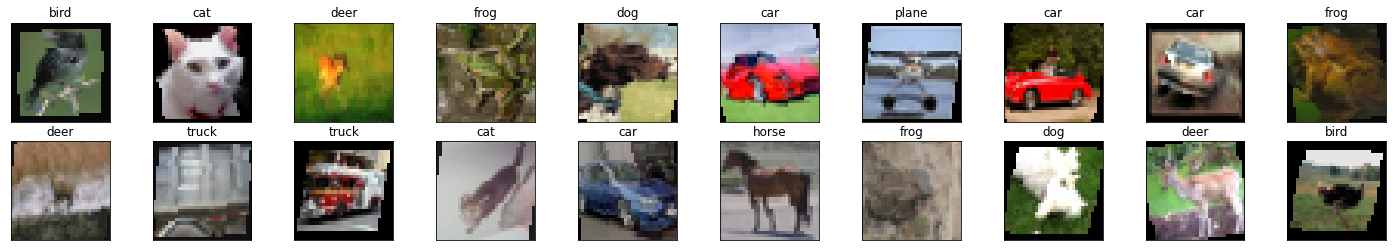

In [9]:
# We iter the batch of images to display
dataiter = iter(training_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [10]:
train_data = DataLoader(training_data, batch_size = 64, shuffle = True)
test_data = DataLoader(testing_data, batch_size = 64, shuffle = True)

In [11]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork,self).__init__()
    self.flatten = nn.Flatten()
    self.layer1 = nn.Linear(32*32*3,512)
    self.layer2 = nn.Linear(512,100)
    self.layer3 = nn.Linear(100,10)
    self.activ = nn.ReLU()
    self.norma = nn.BatchNorm1d(512)
    self.norma2 = nn.BatchNorm1d(100)
    self.dropout = nn.Dropout(0.5)
  def forward(self,x):
    x = self.flatten(x)
    x = self.layer1(x)
    x = self.norma(x)
    x = self.activ(x)
    x = self.layer2(x)
    x = self.norma2(x)
    x = self.activ(x)
    x = self.layer3(x)
    return x

In [12]:
model = NeuralNetwork()
learning_rate = 1e-3

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
model = model.to(device) # run our model on cuda GPU for faster results
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=3072, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=10, bias=True)
  (activ): ReLU()
  (norma): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norma2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # fine tuned the lr

In [18]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device) # input to device as our model is running in mentioned device.
    labels = labels.to(device)
    outputs = model(inputs) # every batch of 100 images are put as an input.
    loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 
    
    optimizer.zero_grad() #setting the initial gradient to 0
    loss.backward() # backpropagating the loss
    optimizer.step() # updating the weights and bias values for every single step.
    
    _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

  else:
    with torch.no_grad(): # we do not need gradient for validation.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(training_loader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.5681, acc 43.5280 
validation loss: 1.4296, validation acc 48.4100 
epoch : 2
training loss: 1.4585, acc 47.5780 
validation loss: 1.3749, validation acc 50.6400 
epoch : 3
training loss: 1.4134, acc 49.2700 
validation loss: 1.3425, validation acc 52.0000 
epoch : 4
training loss: 1.3802, acc 50.6720 
validation loss: 1.3117, validation acc 52.9400 
epoch : 5
training loss: 1.3530, acc 51.8540 
validation loss: 1.3054, validation acc 53.5300 
epoch : 6
training loss: 1.3330, acc 52.4860 
validation loss: 1.3226, validation acc 52.4900 
epoch : 7
training loss: 1.3181, acc 53.0640 
validation loss: 1.2883, validation acc 54.0200 
epoch : 8
training loss: 1.2981, acc 53.6360 
validation loss: 1.2781, validation acc 55.1400 
epoch : 9
training loss: 1.2880, acc 54.1900 
validation loss: 1.2517, validation acc 55.7500 
epoch : 10
training loss: 1.2716, acc 54.6980 
validation loss: 1.2535, validation acc 55.3200 
epoch : 11
training loss: 1.2640, acc 54.8100 
va

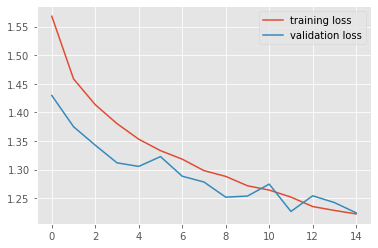

In [19]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

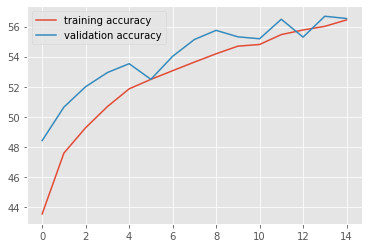

In [20]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

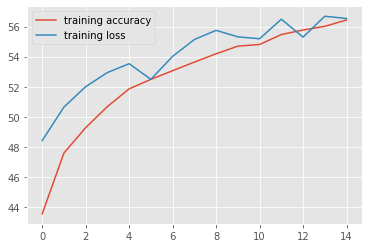

In [21]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='training loss')
plt.legend()

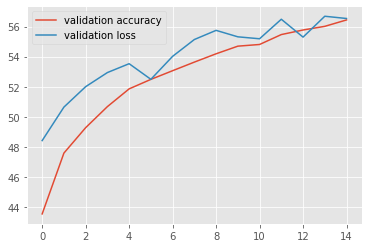

In [22]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label= 'validation accuracy')
plt.plot(val_running_corrects_history, label='validation loss')
plt.legend()